In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(suppress=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

NUM_BITS = 10600
AVG_EMD_BASELINE_EoL = 1.346362954366226

In [2]:
def get_wi(i_bi, i_bw):
    return int(i_bi/i_bw)

def get_wbi(i_bi, i_bw):
    return int(i_bi%i_bw)

def get_wi_wbi(i_bi, i_bw):
    return get_wi(i_bi, i_bw), get_wbi(i_bi, i_bw)

def parse_ranking_file(file):
    """
    Parse the ranking file which contains a list of (bit index, ranking val) 
    into a list of bit indices and a list of ranking values
    """
    bit_indices = []
    vals = []
    with open(file, 'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                # Skip the header
                continue
            line = line.strip()
            if line:
                bit_idx, val = line.split(',')
                bit_indices.append(int(bit_idx))
                vals.append(float(val))
    return bit_indices, vals

In [3]:
ground_truth_rank, ground_truth_emd = parse_ranking_file('encoder_param_ranking_ground_truth.txt')

In [4]:
len(ground_truth_emd)

10600

In [5]:
# Get top 10% highest ranking bits
top_10pct = int(len(ground_truth_rank) * 0.1)
top_10pct_bit_indices = ground_truth_rank[:top_10pct]
top_10pct_emd = ground_truth_emd[:top_10pct]
# Get top 30% highest ranking bits
top_30pct = int(len(ground_truth_rank) * 0.3)
top_30pct_bit_indices = ground_truth_rank[:top_30pct]
top_30pct_emd = ground_truth_emd[:top_30pct]

In [6]:
top_10pct_bit_indices[:15]

[5, 240, 5825, 165, 45, 250, 6, 8145, 2370, 80, 166, 35, 8160, 4325, 125]

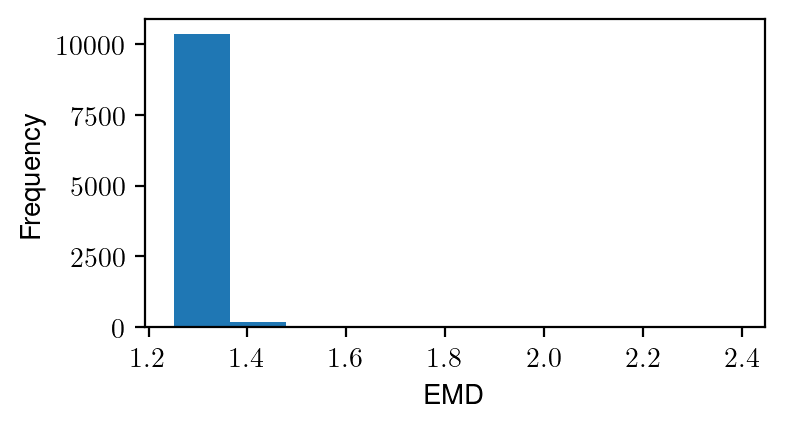

In [7]:
# Plot histogram of the EMD values
fig, ax = plt.subplots(figsize=(4,2)) # Sample figsize in inches
ax.hist(ground_truth_emd)
ax.set_xlabel('EMD')
ax.set_ylabel('Frequency')
plt.savefig('plots/histogram_faulty_emd.pdf', dpi=300, bbox_inches='tight')

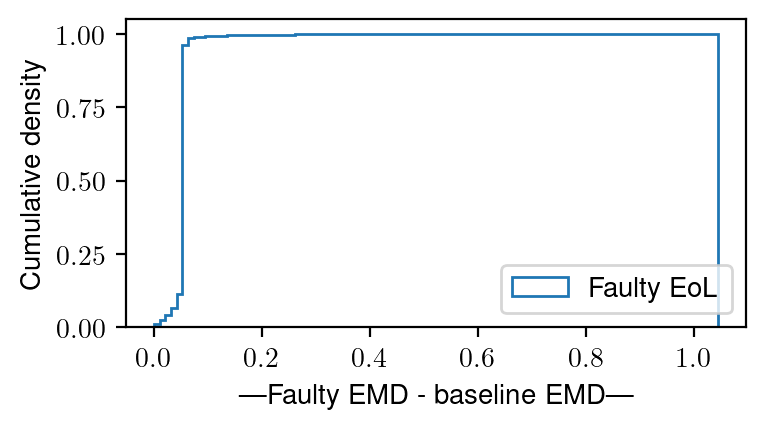

In [8]:
# Plot histogram of the delta EMD values from the baseline
fig, ax = plt.subplots(figsize=(4,2)) # Sample figsize in inches
ax.hist(np.absolute(np.array(ground_truth_emd) - AVG_EMD_BASELINE_EoL), cumulative=True, density=True, bins=100, histtype='step', label='Faulty EoL')
ax.set_xlabel('|Faulty EMD - baseline EMD|')
ax.set_ylabel('Cumulative density')
ax.legend(loc='lower right')
plt.savefig('plots/histogram_faulty_delta_emd.pdf', dpi=300, bbox_inches='tight')

In [22]:
# Convert encoder Hessian parameter ranking to bit indices 
BITWIDTH = 5
conv_hess_rank, conv_hess_score = parse_ranking_file('sensitivity_ranking_layer_conv2d_0_m.txt')
num_conv_bits = len(conv_hess_rank) * BITWIDTH
bit_level_rank_conv = []
for i in conv_hess_rank:
    bit_idx = i * BITWIDTH
    bit_level_rank_conv.append(bit_idx)
    for j in range(1, BITWIDTH):
        bit_level_rank_conv.append(bit_idx + j)
print(len(bit_level_rank_conv))
# Sort from MSB to LSB
conv_sign_bits = bit_level_rank_conv[0::BITWIDTH]
conv_int_bits = bit_level_rank_conv[1::BITWIDTH]
conv_frac_bits = np.concatenate((bit_level_rank_conv[2::BITWIDTH], bit_level_rank_conv[3::BITWIDTH], bit_level_rank_conv[4::BITWIDTH]))
conv_bit_rank = np.concatenate((conv_sign_bits, conv_int_bits, conv_frac_bits))

dense_hess_rank, dense_hess_score = parse_ranking_file('sensitivity_ranking_layer_encoded_vector.txt')
num_dense_bits = len(dense_hess_rank) * BITWIDTH
bit_level_rank_dense = []
for i in dense_hess_rank:
    bit_idx = i * BITWIDTH + num_conv_bits
    bit_level_rank_dense.append(bit_idx)
    for j in range(1, BITWIDTH):
        bit_level_rank_dense.append(bit_idx + j)
print(f"dense bit level rank: {bit_level_rank_dense[:10]}")
# Sort from MSB to LSB
dense_sign_bits = bit_level_rank_dense[0::BITWIDTH]
dense_int_bits = bit_level_rank_dense[1::BITWIDTH]
dense_frac_bits = np.concatenate((bit_level_rank_dense[2::BITWIDTH], bit_level_rank_dense[3::BITWIDTH], bit_level_rank_dense[4::BITWIDTH]))
dense_bit_rank = np.concatenate((dense_sign_bits, dense_int_bits, dense_frac_bits))
hessian_rank = np.concatenate((conv_bit_rank, dense_bit_rank))
print(len(hessian_rank))

360
dense bit level rank: [4310, 4311, 4312, 4313, 4314, 4340, 4341, 4342, 4343, 4344]
10600


Found all bits with random at 10589 bits flipped
Found all bits with deterministic at 9070 bits flipped
Found all bits with bit ordered at 10246 bits flipped
Found all bits with Hessian at 8931 bits flipped


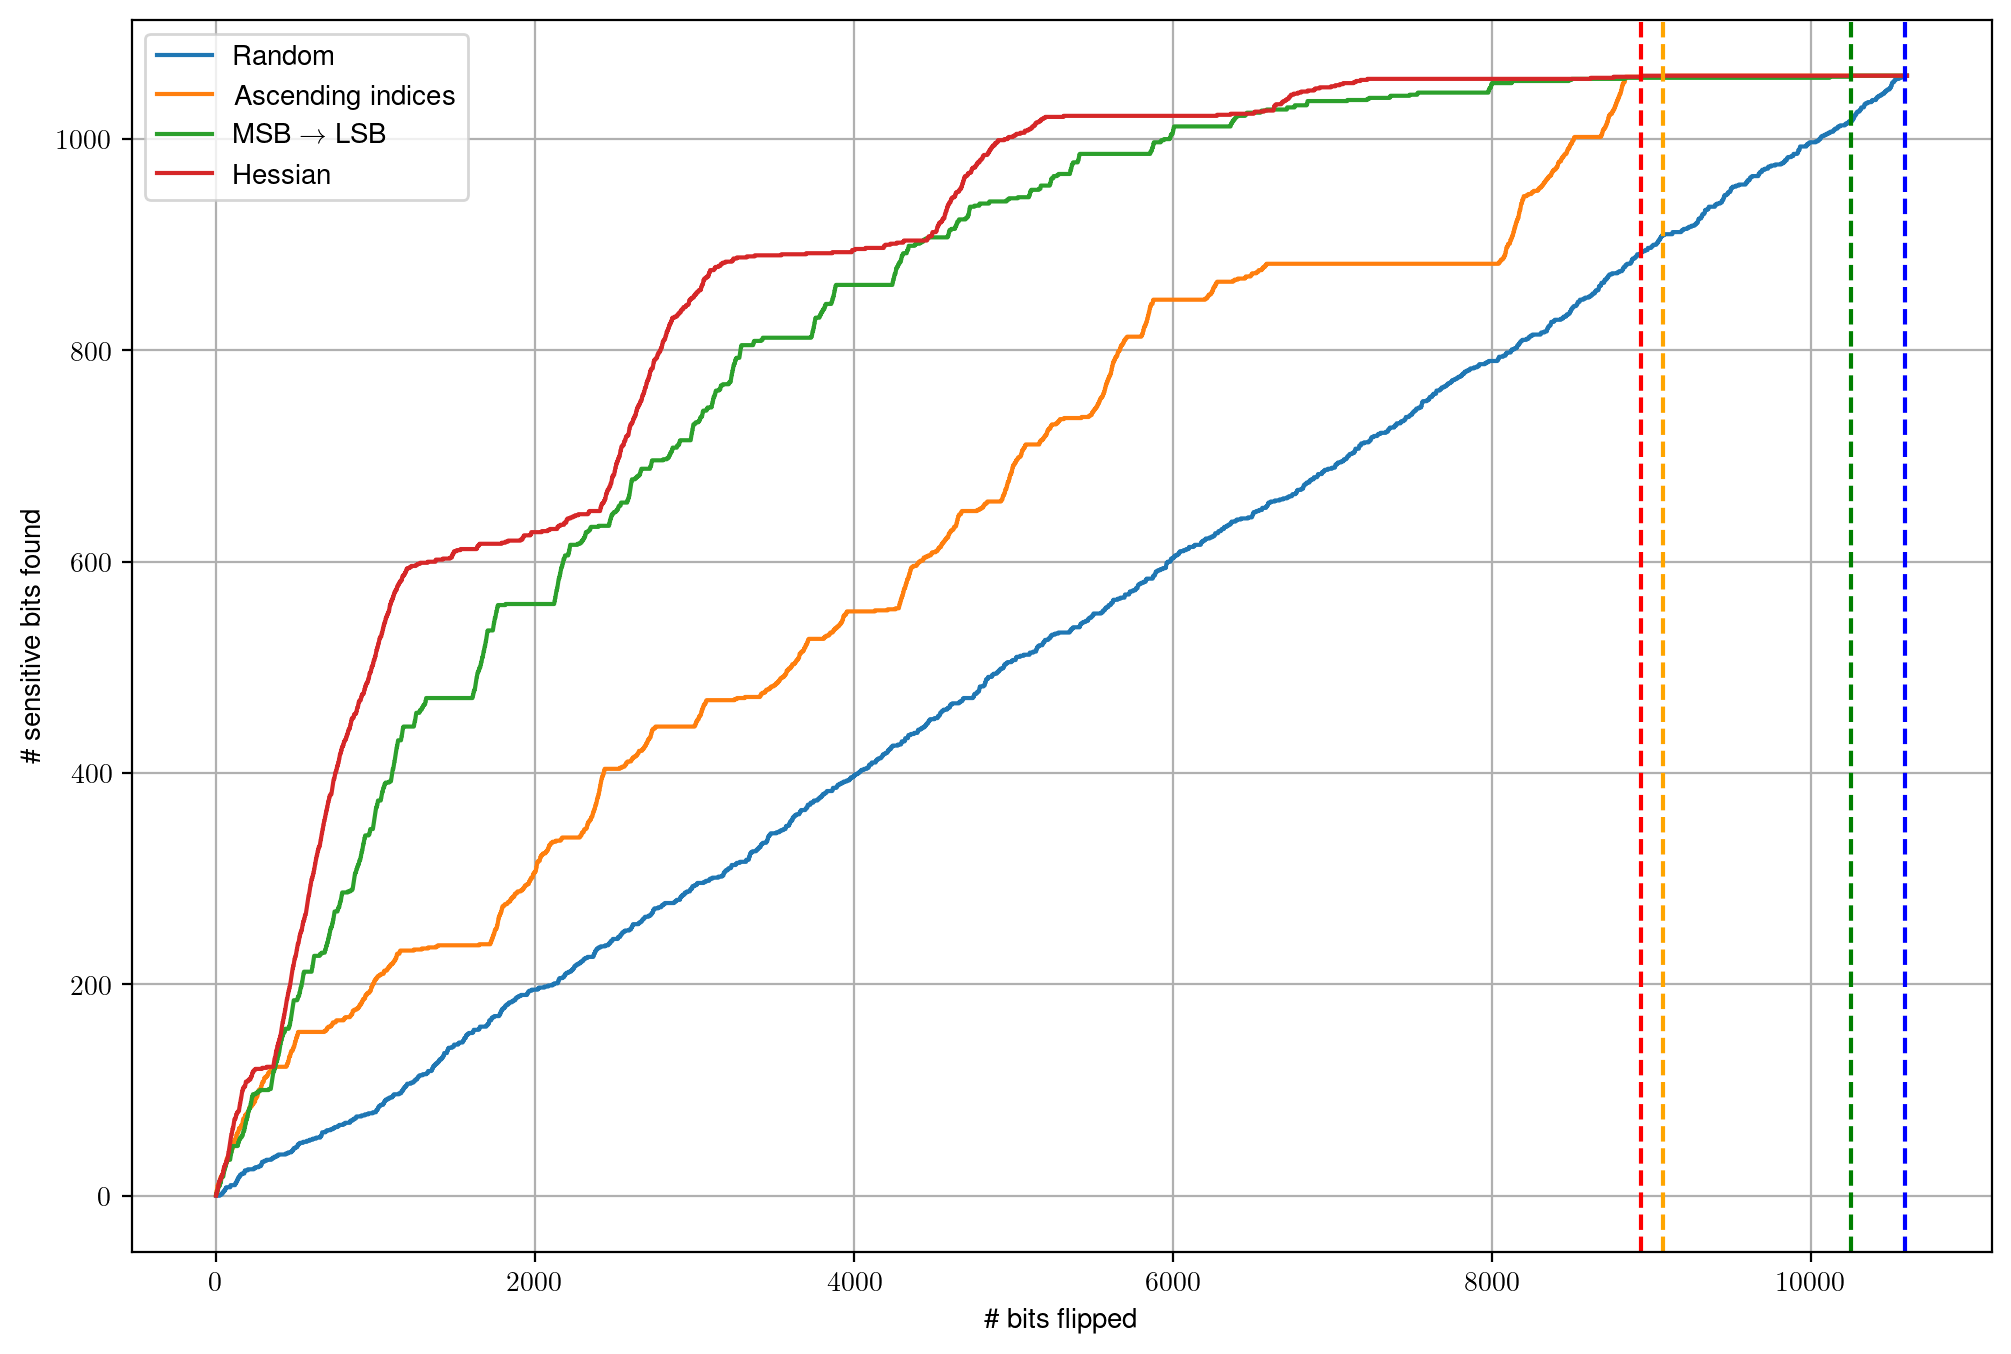

In [34]:
# Generate random list of bit indices to simulate random fault injection
random.seed(7654)
random_bit_indices = random.sample(range(NUM_BITS), NUM_BITS)
deterministic_bit_indices = np.arange(NUM_BITS)
# Search all sign bits first, then integer bits, then fractional bits
bit_ordered_indices = []
sign_bits = deterministic_bit_indices[0::5]
int_bits = deterministic_bit_indices[1::5]
frac_bits = np.concatenate((deterministic_bit_indices[2::5], deterministic_bit_indices[3::5], deterministic_bit_indices[4::5]))
bit_ordered_indices = np.concatenate((sign_bits, int_bits, frac_bits))

random_found = []
hessian_found = []
bit_ordered_found = []
deterministic_found = []
for i in range(NUM_BITS):
    if random_bit_indices[i] in top_10pct_bit_indices:
        random_found.append(1)
    if random_bit_indices[i] not in top_10pct_bit_indices:
        random_found.append(0)
    if deterministic_bit_indices[i] in top_10pct_bit_indices:
        deterministic_found.append(1)
    if deterministic_bit_indices[i] not in top_10pct_bit_indices:
        deterministic_found.append(0)
    if bit_ordered_indices[i] in top_10pct_bit_indices:
        bit_ordered_found.append(1)
    if bit_ordered_indices[i] not in top_10pct_bit_indices:
        bit_ordered_found.append(0)
    if hessian_rank[i] in top_10pct_bit_indices:
        hessian_found.append(1)
    if hessian_rank[i] not in top_10pct_bit_indices:
        hessian_found.append(0)
random_found = np.cumsum(np.array(random_found))
random_all_bits_found = np.argwhere(random_found == 1060)[0][0]
print(f"Found all bits with random at {random_all_bits_found} bits flipped")
deterministic_found = np.cumsum(np.array(deterministic_found))
deterministic_all_bits_found = np.argwhere(deterministic_found == 1060)[0][0]
print(f"Found all bits with deterministic at {deterministic_all_bits_found} bits flipped")
bit_ordered_found = np.cumsum(np.array(bit_ordered_found))
bit_ordered_all_bits_found = np.argwhere(bit_ordered_found == 1060)[0][0]
print(f"Found all bits with bit ordered at {bit_ordered_all_bits_found} bits flipped")
hessian_found = np.cumsum(np.array(hessian_found))
hess_all_bits_found = np.argwhere(hessian_found == 1060)[0][0]
print(f"Found all bits with Hessian at {hess_all_bits_found} bits flipped")


# Plot cdf
fig, ax = plt.subplots(figsize=(12,8)) # Sample figsize in inches
ax.plot(np.arange(NUM_BITS), random_found, label='Random')
ax.plot(np.arange(NUM_BITS), deterministic_found, label='Ascending indices')
ax.plot(np.arange(NUM_BITS), bit_ordered_found, label=r'MSB $\rightarrow$ LSB')
ax.plot(np.arange(NUM_BITS), hessian_found, label='Hessian')
ax.set_xlabel('\# bits flipped')
ax.set_ylabel('\# sensitive bits found')
ax.legend()
ax.grid()
plt.axvline(x=random_all_bits_found, color='blue', linestyle='--')
plt.axvline(x=deterministic_all_bits_found, color='orange', linestyle='--')
plt.axvline(x=bit_ordered_all_bits_found, color='green', linestyle='--')
plt.axvline(x=hess_all_bits_found, color='red', linestyle='--')
plt.savefig('plots/fault_sensitivity_ranking.pdf', dpi=300, bbox_inches='tight')